# Исследование рыночной корзины на основе данных розничной торговли в Стамбуле

In [1]:
# импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

In [2]:
# подгружаем данные
data = pd.read_csv('customer_shopping_data.csv')
data.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


Цель этой задачи - получить представление о тенденциях и моделях покупок в Стамбуле. Давайте посмотрим на полный список доступных признаков:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


Пропусков в данных нет, 6 категориальных (`invoice_no`, `customer_id`, `gender`, `category`, `payment_method`, `invoice_date`, `shopping_mall`) и 3 количественных признаков (`age`,`quantity`, `price`)

Вот полное описание этих признаков:
    
* `invoice_no`: Номер счета. 
* `customer_id`: Номер клиента.
* `gender`: Пол.
* `age`: Возраст клиентов.
* `category`: Категории приобретаемого товара
* `quantity`: Количество каждого продукта (элемента) на транзакцию.
* `price`: Цена товара за единицу в турецких лирах (TL).
* `payment_method`: Способа оплаты (наличными, кредитной картой или дебетовой картой), используемого для транзакции.
* `invoice_date`: Дата выставления счета. День, когда была создана транзакция.
* `shopping_mall`: Названия торгового центра, в котором была совершена транзакция.

Теперь давайте посмотрим уникальность значений:

In [4]:
unique_counts = data.nunique()
unique_counts

invoice_no        99457
customer_id       99457
gender                2
age                  52
category              8
quantity              5
price                40
payment_method        3
invoice_date        797
shopping_mall        10
dtype: int64

Каждый номер клиента и номер счета уникальный, значит не было повторов, из чего следует, что невозможно анализировать покупки на основе клиентов. Удалим данные столбцы:

In [5]:
cols_2_drop = ['invoice_no', 'customer_id']
data = data.drop(cols_2_drop, axis=1)
data = data.dropna()
data.head()

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


Признак `invoice_data` не корректно указан. Добавим дополнительно 3 столбца с указанием года, месяца и дня:

In [6]:
data['invoice_date'] = pd.to_datetime(data['invoice_date'], dayfirst=True)
data['year'] = data['invoice_date'].dt.strftime("%Y")
data['month'] = data['invoice_date'].dt.strftime("%m")
data['day'] = data['invoice_date'].dt.strftime("%d")

day_of_week ={
    0: 'Monday', 
    1: 'Tuesday', 
    2: 'Wednesday', 
    3: 'Thursday', 
    4: 'Friday',
    5: 'Saturday', 
    6: 'Sunday'
} 

data['dayofweek']= data['invoice_date'].dt.weekday.map(day_of_week)

data.head()

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,year,month,day,dayofweek
0,Female,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon,2022,08,05,Friday
1,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,2021,12,12,Sunday
2,Male,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity,2021,11,09,Tuesday
3,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,2021,05,16,Sunday
4,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,2021,10,24,Sunday


In [7]:
data.describe()

,age,quantity,price
count,99457.000000,99457.000000,99457.000000
mean,43.427089,3.003429,689.256321
std,14.990054,1.413025,941.184567
min,18.000000,1.000000,5.230000
25%,30.000000,2.000000,45.450000
50%,43.000000,3.000000,203.300000
75%,56.000000,4.000000,1200.320000
max,69.000000,5.000000,5250.000000


Возраст клиентов от 18 до 69 лет, кол-во каждого продукта - от 1 до 5, самая дешевая/дорогая покупка - 5,23/5250 TL. Объединим `age` в возрастные группы и выведим общую сумму расходов(`price`*`quantity`):

In [8]:
age_groups = [18, 24, 44, 59, 69]
labels = ['18-24','25-44','45-59','60-69']
data['age_group'] = pd.cut(data['age'],bins=age_groups, labels =labels)
age_cats = pd.CategoricalDtype(['18-24','25-44','45-59','60-69'], ordered=True)
data['age_group'] = data['age_group'].astype(age_cats)

In [9]:
data['total'] = data['price'] * data['quantity']
data.head()

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,year,month,day,dayofweek,age_group,total
0,Female,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon,2022,08,05,Friday,25-44,7502.00
1,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,2021,12,12,Sunday,18-24,5401.53
2,Male,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity,2021,11,09,Tuesday,18-24,300.08
3,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,2021,05,16,Sunday,60-69,15004.25
4,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,2021,10,24,Sunday,45-59,242.40


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   gender          99457 non-null  object        
 1   age             99457 non-null  int64         
 2   category        99457 non-null  object        
 3   quantity        99457 non-null  int64         
 4   price           99457 non-null  float64       
 5   payment_method  99457 non-null  object        
 6   invoice_date    99457 non-null  datetime64[ns]
 7   shopping_mall   99457 non-null  object        
 8   year            99457 non-null  object        
 9   month           99457 non-null  object        
 10  day             99457 non-null  object        
 11  dayofweek       99457 non-null  object        
 12  age_group       97613 non-null  category      
 13  total           99457 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(2

In [11]:
g_p = data.groupby('gender')[['price']].sum().reset_index()
g_p

,gender,price
0,Female,40931801.62
1,Male,27619564.29


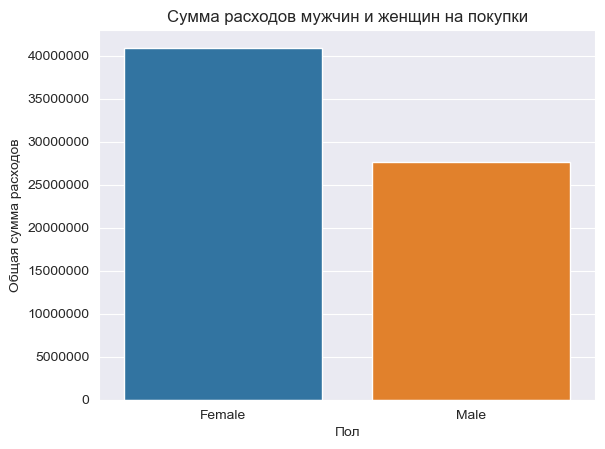

In [12]:
sns.barplot(x='gender',y='price',data= g_p)
plt.ylabel('Общая сумма расходов')
plt.xlabel('Пол')
plt.title('Сумма расходов мужчин и женщин на покупки')
plt.ticklabel_format(style='plain',axis='y')
plt.show()

In [13]:
cat_p =data.groupby('category')[['price']].sum().reset_index()
cat_p

,category,price
0,Books,226977.30
1,Clothing,31075684.64
2,Cosmetics,1848606.90
3,Food & Beverage,231568.71
4,Shoes,18135336.89
5,Souvenir,174436.83
6,Technology,15772050.00
7,Toys,1086704.64


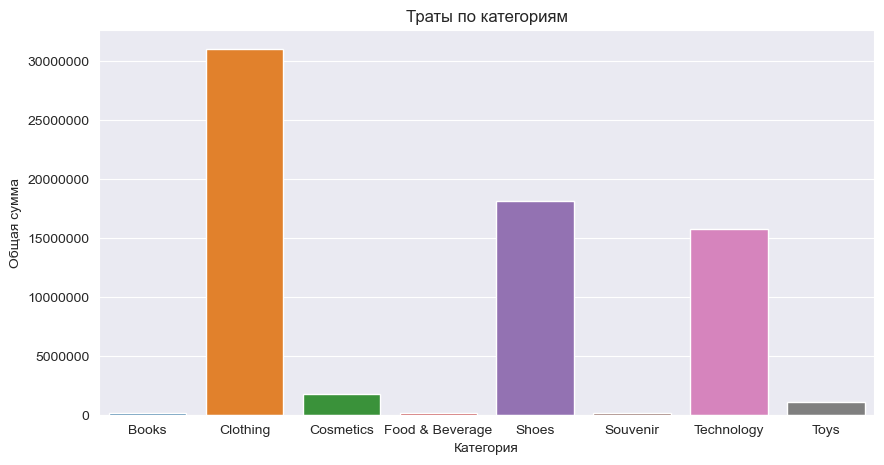

In [14]:
plt.figure(figsize=(10,5))
sns.barplot(x='category',y='price',data=cat_p)
plt.title('Траты по категориям')
plt.ylabel('Общая сумма')
plt.xlabel('Категория')
plt.ticklabel_format(style='plain',axis='y')
plt.show()

In [15]:
pay_p =data.groupby('payment_method')[['price']].sum().reset_index()
pay_p

,payment_method,price
0,Cash,30705030.98
1,Credit Card,24051476.93
2,Debit Card,13794858.00


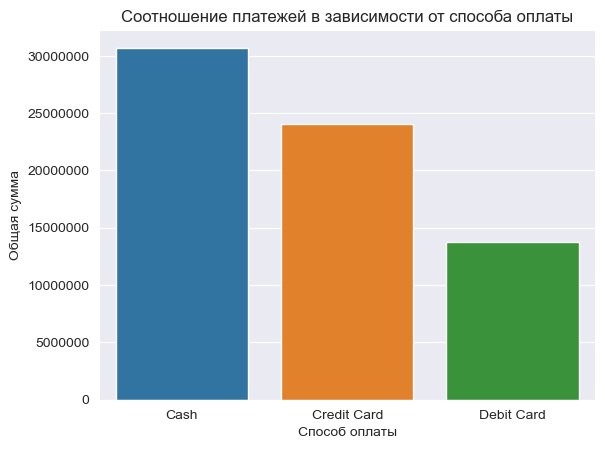

In [16]:
sns.barplot(x='payment_method',y='price',data=pay_p)
plt.title('Соотношение платежей в зависимости от способа оплаты')
plt.ticklabel_format(style='plain',axis='y')
plt.ylabel('Общая сумма')
plt.xlabel('Способ оплаты')
plt.show()

In [17]:
pd.crosstab([data.age_group, data.gender], data.category, values=data.total, aggfunc=np.sum, normalize='columns').\
applymap(lambda x: "{0:.0f}%".format(100*x))

category         Books Clothing Cosmetics Food & Beverage Shoes Souvenir  \
age_group gender                                                           
18-24     Female    7%       7%        7%              7%    7%       7%   
          Male      6%       5%        4%              5%    5%       5%   
25-44     Female   24%      24%       24%             24%   23%      24%   
          Male     15%      16%       16%             16%   16%      16%   
45-59     Female   16%      17%       17%             17%   17%      18%   
          Male     12%      12%       12%             12%   12%      11%   
60-69     Female   11%      12%       12%             12%   11%      11%   
          Male      8%       8%        8%              8%    8%       8%   

category         Technology Toys  
age_group gender                  
18-24     Female         7%   7%  
          Male           4%   5%  
25-44     Female        24%  24%  
          Male          16%  15%  
45-59     Female        17%  17%  
          Male          11%  12%  
60-69     Female        12%  12%  
          Male           8%   8%

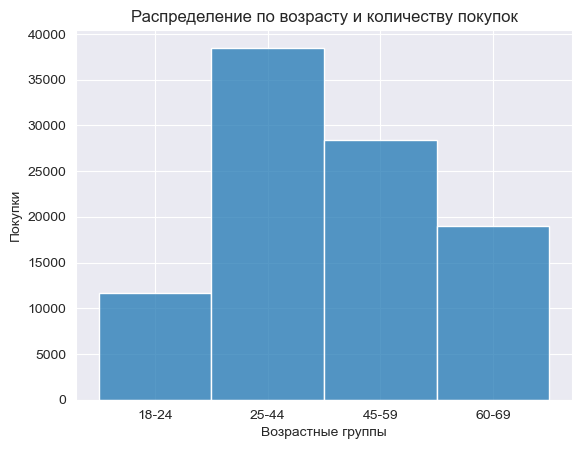

In [18]:
sns.histplot(data=data, x='age_group')
plt.title('Распределение по возрасту и количеству покупок')
plt.ylabel('Покупки')
plt.xlabel('Возрастные группы')
plt.show()

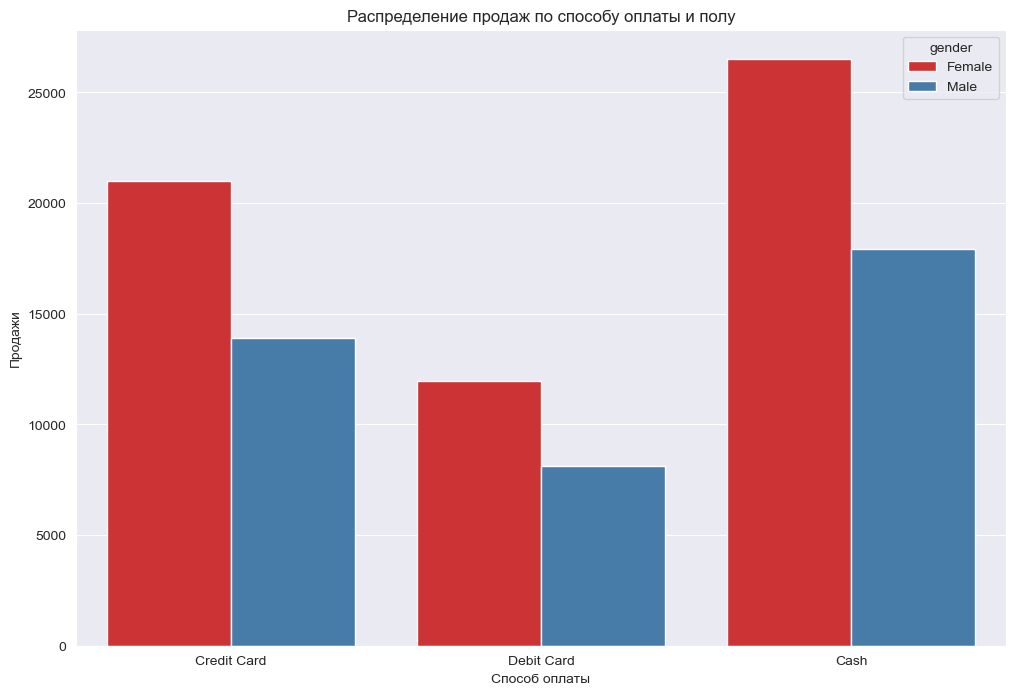

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.countplot(data=data, x='payment_method', hue='gender', palette='Set1', ax=ax)

ax.set_title('Распределение продаж по способу оплаты и полу')
ax.set_xlabel('Способ оплаты')
ax.set_ylabel('Продажи')

plt.show()

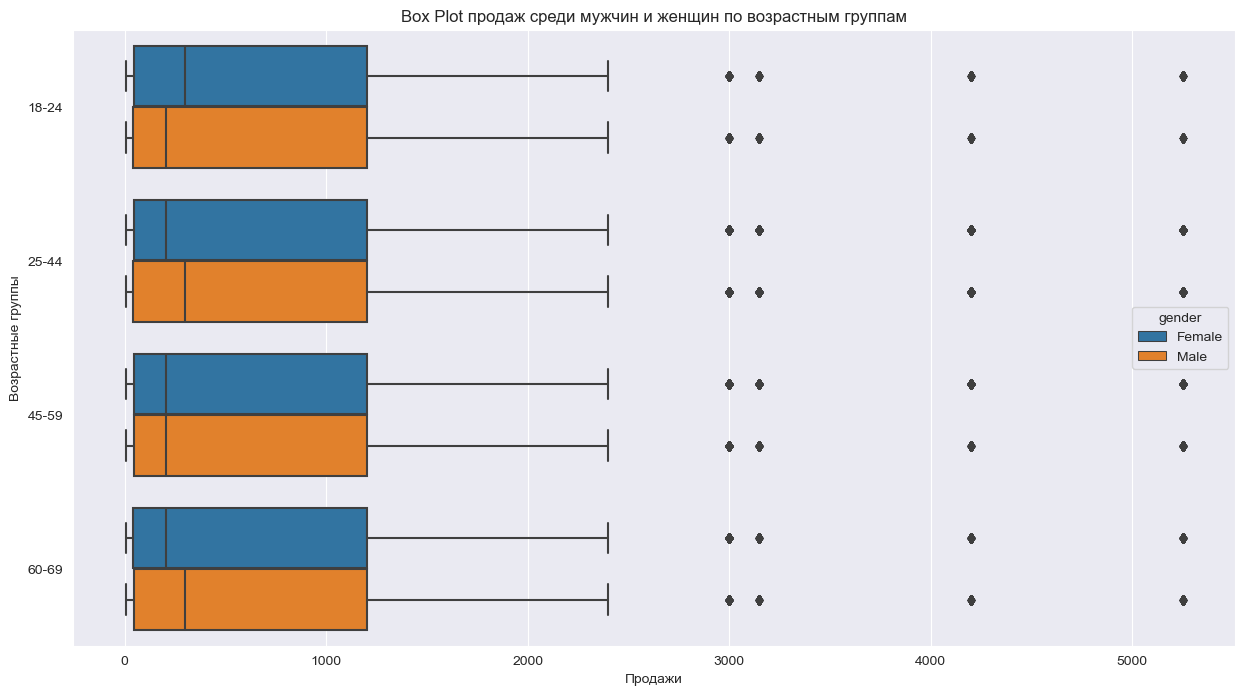

In [20]:
plt.figure(figsize=(15,8))
sns.boxplot(data=data, x='price', y='age_group', hue='gender')
plt.title('Box Plot продаж среди мужчин и женщин по возрастным группам')
plt.ylabel('Возрастные группы')
plt.xlabel('Продажи')
plt.show() 

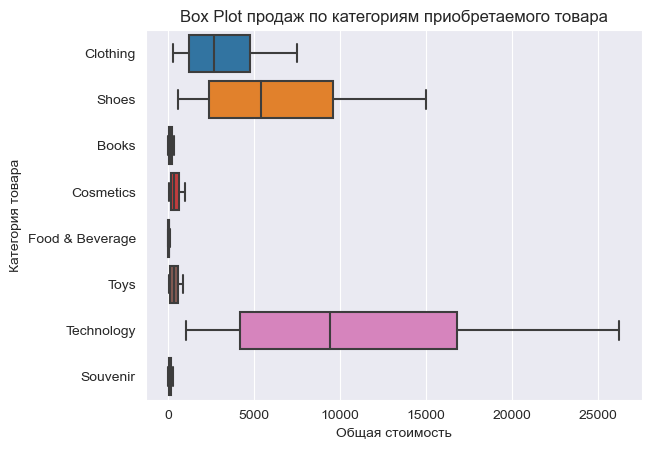

In [21]:
sns.boxplot(x='total', y='category', data=data)
plt.title('Box Plot продаж по категориям приобретаемого товара')
plt.ylabel('Категория товара')
plt.xlabel('Общая стоимость')
plt.show()

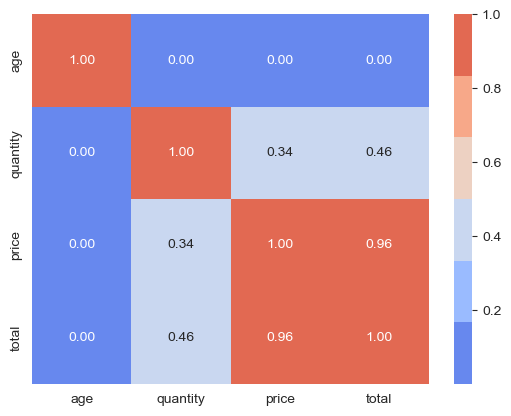

In [22]:
plt.subplots
sns.heatmap(data.corr(), fmt=".2f", cmap=sns.color_palette("coolwarm"),annot=True)
plt.show()

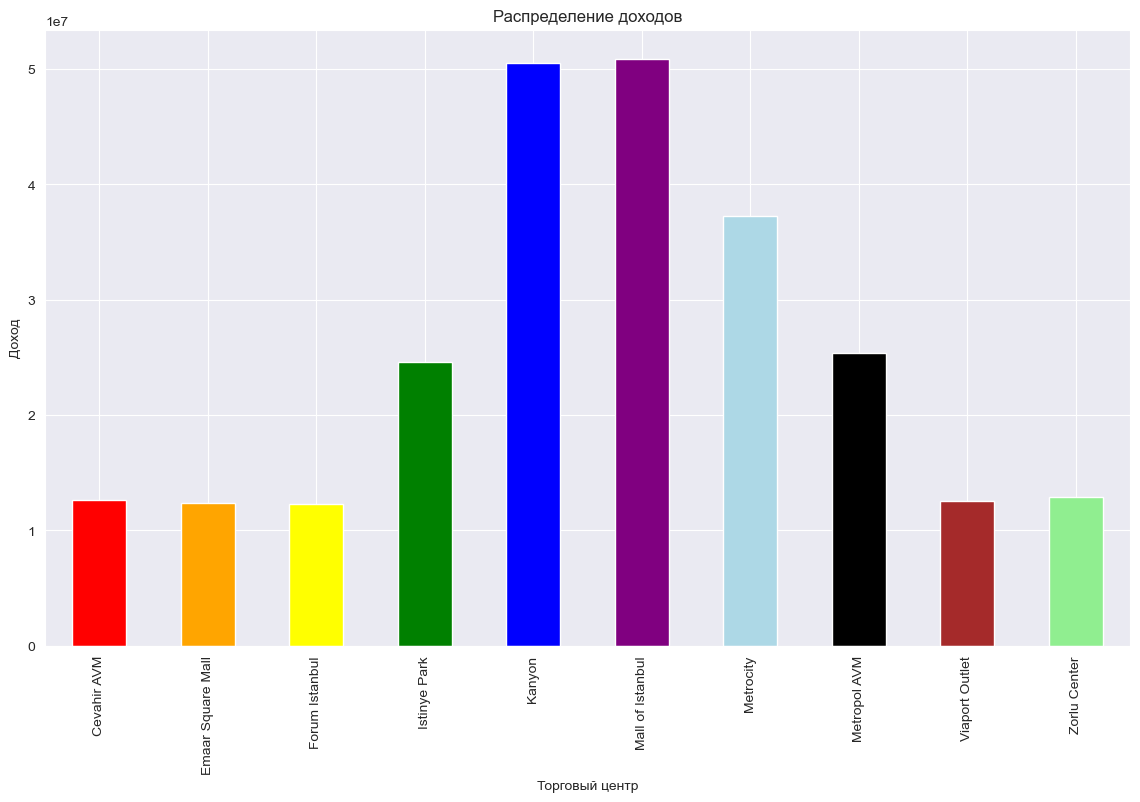

In [23]:
colors = ['red', 'orange', 'yellow', 'green','blue', 'purple','lightblue' ,'black', 'brown', 'lightgreen']
data_mall = data.groupby("shopping_mall")["total"].sum()
data_mall.plot(kind="bar",figsize=(14, 8),color=colors)

plt.title('Распределение доходов')
plt.ylabel('Доход')
plt.xlabel('Торговый центр')
plt.show()

In [24]:
pd.DataFrame(data['shopping_mall'].value_counts())

,shopping_mall
Mall of Istanbul,19943
Kanyon,19823
Metrocity,15011
Metropol AVM,10161
Istinye Park,9781
Zorlu Center,5075
Cevahir AVM,4991
Forum Istanbul,4947
Viaport Outlet,4914
Emaar Square Mall,4811


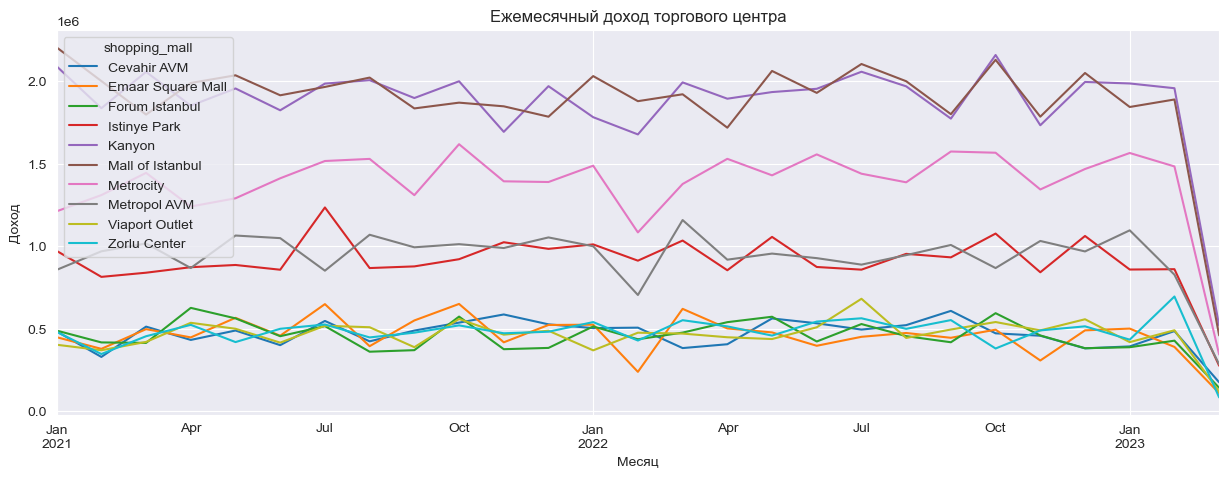

In [25]:
data['invoice_date'] = pd.to_datetime(data['invoice_date'])
data.set_index('invoice_date', inplace=True)

mall_total = data.groupby(['shopping_mall', pd.Grouper(freq='M')])['total'].sum()
mall_total = mall_total.reset_index()
mall_total = mall_total.pivot(index='invoice_date', columns='shopping_mall', values='total')
mall_total.plot(figsize=(15, 5))
plt.title('Ежемесячный доход торгового центра')
plt.ylabel('Доход')
plt.xlabel('Месяц')
plt.show()

Text(0.5, 0, 'День')

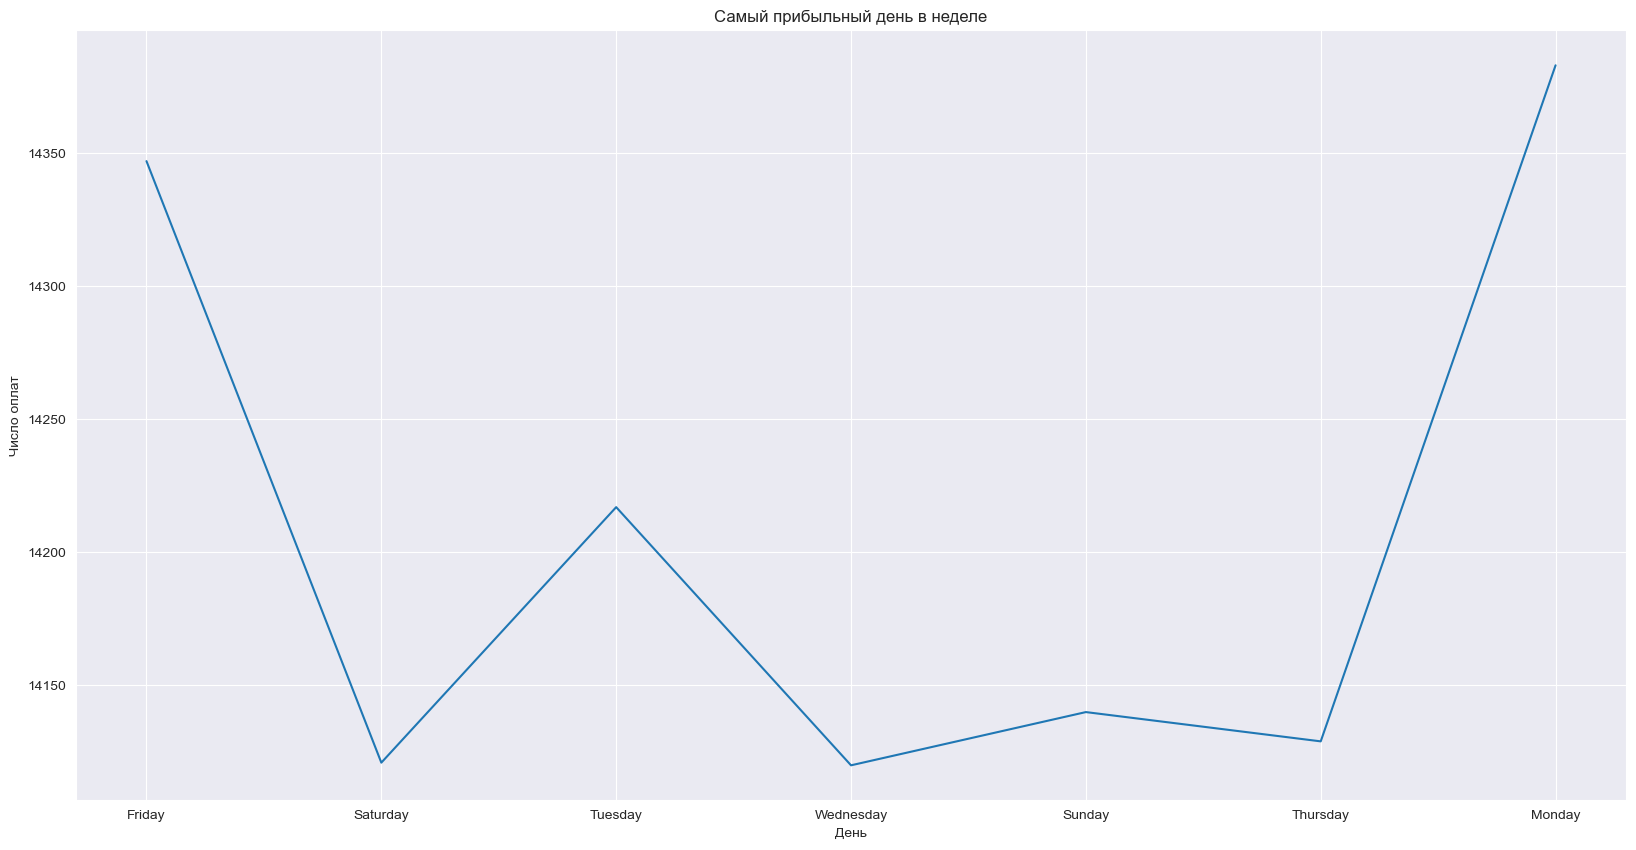

In [26]:
#data['dayofweek']= data['invoice_date'].dt.weekday.map(dw_mapping)
#day_of_w_mapping={
   # 0: 'Monday', 
    #1: 'Tuesday', 
    #2: 'Wednesday', 
    #3: 'Thursday', 
    #4: 'Friday',
    #5: 'Saturday', 
    #6: 'Sunday'}  

data_sorted_weekday = data.sort_values(['day'], ascending=True, axis=0, inplace=False)

ax = data_sorted_weekday['dayofweek'].value_counts()\
[data_sorted_weekday['dayofweek'].unique()]\
.plot(kind='line',figsize=(20,10),alpha=1.0)

ax.set_title('Самый прибыльный день в неделе')
ax.set_ylabel('Число оплат')
ax.set_xlabel('День')

In [27]:
pd.crosstab([data.age_group, data.gender], data.category, values=data.total, aggfunc=np.sum, normalize='columns').\
applymap(lambda x: "{0:.0f}%".format(100*x))

category         Books Clothing Cosmetics Food & Beverage Shoes Souvenir  \
age_group gender                                                           
18-24     Female    7%       7%        7%              7%    7%       7%   
          Male      6%       5%        4%              5%    5%       5%   
25-44     Female   24%      24%       24%             24%   23%      24%   
          Male     15%      16%       16%             16%   16%      16%   
45-59     Female   16%      17%       17%             17%   17%      18%   
          Male     12%      12%       12%             12%   12%      11%   
60-69     Female   11%      12%       12%             12%   11%      11%   
          Male      8%       8%        8%              8%    8%       8%   

category         Technology Toys  
age_group gender                  
18-24     Female         7%   7%  
          Male           4%   5%  
25-44     Female        24%  24%  
          Male          16%  15%  
45-59     Female        17%  17%  
          Male          11%  12%  
60-69     Female        12%  12%  
          Male           8%   8%

#### Моделирование

In [28]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [29]:
data_model = data[['gender', 'age_group', 'category', 'price', 'total']]

data_dummy = pd.get_dummies(data_model)
data_dummy.head()

,price,total,gender_Female,gender_Male,age_group_18-24,age_group_25-44,age_group_45-59,age_group_60-69,category_Books,category_Clothing,category_Cosmetics,category_Food & Beverage,category_Shoes,category_Souvenir,category_Technology,category_Toys
invoice_date,,,,,,,,,,,,,,,,
2022-08-05,1500.40,7502.00,1,0,0,1,0,0,0,1,0,0,0,0,0,0
2021-12-12,1800.51,5401.53,0,1,1,0,0,0,0,0,0,0,1,0,0,0
2021-11-09,300.08,300.08,0,1,1,0,0,0,0,1,0,0,0,0,0,0
2021-05-16,3000.85,15004.25,1,0,0,0,0,1,0,0,0,0,1,0,0,0
2021-10-24,60.60,242.40,1,0,0,0,1,0,1,0,0,0,0,0,0,0


In [30]:
X_train, X_test, y_train, y_test = train_test_split(data_dummy.drop('total', axis=1), data_dummy.total, \
                                                    test_size=0.33, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

NameError: name 'StandardScaler' is not defined

In [ ]:
results={}

for model in LinearRegression(),DecisionTreeRegressor(max_depth=5,min_samples_split=6,max_leaf_nodes=10),\
    Lasso(alpha = 100),Ridge(alpha = 100),ElasticNet(alpha = 100):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    result={}
    result["Test MAE"] = mean_absolute_error(y_test, y_pred)
    result["Train MAE"] = mean_absolute_error(y_train, y_train_pred)
    result["Test MSE"] = mean_squared_error(y_test, y_pred)
    result["Train MSE"] = mean_squared_error(y_train, y_train_pred)
    result["R2 score"] = r2_score(y_test, y_pred) 
    result["Cross validatio"] = np.mean(cross_val_score(model,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 3))
    results[type(model).__name__] = result
pd.DataFrame(results)